In [1]:
import numpy as np
import scipy.stats as stats
import random

import math
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import ScalarFormatter

In [2]:
# Define Tableau 10 Colors
tableau_colors = [
    (31, 119, 180),  # Blue 0
    (255, 127, 14),  # Orange 1
    (44, 160, 44),   # Green 2
    (214, 39, 40),   # Red 3
    (148, 103, 189), # Purple 4 
    (140, 86, 75),   # Brown 5
    (227, 119, 194), # Pink 6
    (127, 127, 127), # Gray 7
    (188, 189, 34),  # Yellow 8
    (23, 190, 207),  # Cyan 9
]

# Normalize RGB values to range [0, 1]
tableau_colors = [(r / 255, g / 255, b / 255) for r, g, b in tableau_colors]

font = {'family': 'Georgia', 'color':  'black', 'weight': 'normal', 'size': 20}
title_font = {'family': 'Georgia', 'color':  'black', 'weight': 'bold', 'style': 'italic', 'size': 20}
suptitle_font = FontProperties(family='Georgia', weight='bold', size=22)
legend_font = FontProperties(family='Georgia', weight='normal', size=16)
tick_font = {'family': 'Georgia', 'size': 18}

In [3]:
# global constants
ATOM_NUMBER = 12.01
AVOGADRO = 6.022e23
DENSITY = 2.1

n_bin_energy = 100
n_monte_carlo = 10000

In [4]:
def get_neutron_energy():
    """USE VON NEUMANN'S METHOD ("HIT AND MISS") TO CALCULATE THE 
    ENERGY OF THE NEUTRON EMITED FROM A FISSION SOURCE."""
    alpha = 1.4 # MeV, fitting parameter
    while True:
        rand_energy = random.random() * 9.999 # MeV, 9.999 is higher than max possible
        prob = math.sqrt(rand_energy) * math.exp(-rand_energy / alpha)
        rand_prob = random.random() * 0.5 # probability, 0.5 is higher than max possible
        if rand_prob > prob:
            continue
        return rand_energy

In [5]:
def get_cross_sections(energy):
    """RETURNS THE APPROXIMATE CROSS SECTIONS (BARNS) FOR ABSORPTION AND 
    ELASTIC SCATTERING IN CARBON. HERE WE NEED THE ENERGY IN EV, NOT MEV."""
    E_eV = energy * 1e6
    if E_eV < 1e4:
        sigma_elastic = 5
    else:
        sigma_elastic = 10.5 - (1.346 * math.log10(E_eV))
    sigma_elastic /= 1e24 
    
    if E_eV < 1e3:
        sigma_absorb = (6.442e-4) * (E_eV ** (-0.49421)) 
    elif E_eV < 1e5:
        sigma_absorb = 1.5e-5
    elif E_eV < 5e6:
        sigma_absorb = 2e-5
    else:
        sigma_absorb = (4e-6) * math.exp(E_eV * 3.2189e-7) 
    sigma_absorb /= 1e24 
    
    return sigma_elastic, sigma_absorb

In [13]:
def get_euler_angles(vx_0, vy_0, vz_0, zenith):
    """THIS SUBROUTINE TAKES THE ORIGINAL LINEAR TRAJECTORY,
    ROTATES IT TO LIE ALONG THE Z-AXIS, GENERATES A VECTOR
    AT ZENITH ANGLE THETA = SCATTERING ANGLE 
    AND AZIMUTHAL ANGLE PHI = RANDOM * 2PI. 
    THE ORIGINAL AXIS IS NOW ROTATED BACK TAKING THE SCATTERING VECTOR WITH IT. 
    NOW WE HAVE THE SCATTERED DIRECTION VECTOR (SX,SY,SZ).
    WE USE EULER ANGLES TO PERFORM THE TRANSFORMATION."""
#     direction of unit vector 
    s = (vx_0 ** 2.0 + vy_0 ** 2.0 + vz_0 ** 2.0) ** 0.5
    vx_0, vy_0, vz_0 = vx_0 / s, vy_0 / s, vz_0 / s
    beta = math.acos(vz_0)
    
#     only needed for Cmopton scattering for gamma, but won't hurt here
    if abs(beta) < 0.027:
        alpha = 0.0
    else:
        arg = vy_0 / math.sin(beta)
        if abs(arg) < 1.0:
            alpha = math.asin(arg)
        else:
            arg = arg / (1.0001 * abs(arg))
            alpha = math.asin(arg)

    sc1_0 = abs(math.cos(alpha) * math.sin(beta) + vx_0)
    sc2_0 = abs(vx_0)
    if sc1_0 < sc2_0:
        alpha, beta = -alpha, -beta

    gamma = 0.0
#     we now have Euler angles of rotation between z-axis to direction of initial particle
    theta = zenith
    phi = 6.2831853 * random.random()
    
#     NOW HAVE SCATTERED THE PARTICLE FROM THE Z-AXIS 
#     AND MUST ROTATE IT TO THE ORIGINAL UNSCATTERED PARTICLE DIRECTION. 
    sx_0 = math.sin(theta) * math.cos(phi)
    sy_0 = math.sin(theta) * math.sin(phi)
    sz_0 = math.cos(theta)
    s_0 = np.array([sx_0, sy_0, sz_0])
    
#     rotation matrix
    R11 = math.cos(alpha)*math.cos(beta) *math.cos(gamma)-math.sin(alpha)*math.sin(gamma)
    R12 = math.cos(beta) *math.sin(alpha)*math.cos(gamma)+math.cos(alpha)*math.sin(gamma)
    R13 =-math.sin(beta) *math.cos(gamma)
    R21 =-math.sin(gamma)*math.cos(beta) *math.cos(alpha)-math.sin(alpha)*math.cos(gamma)
    R22 =-math.sin(gamma)*math.cos(beta) *math.sin(alpha)+math.cos(alpha)*math.cos(gamma)
    R23 = math.sin(beta) *math.sin(gamma)
    R31 = math.sin(beta) *math.cos(alpha)
    R32 = math.sin(alpha)*math.sin(beta)
    R33 = math.cos(beta)
    R = np.array([[R11, R21, R31], [R12, R22, R32], [R13, R23, R33]])
    
    vx_f, vy_f, vz_f = np.dot(R, s_0)
    
    return vx_f, vy_f, vz_f

In [7]:
def get_energy_loss(energy):
    """CALCULATE ENERGY LOSS IN COLLISION, USE ISOTROPIC (S-WAVE) 
    APPROXIMATION. ROUND UP ANY ENERGY BELOW 0.1 EV TO 0.02 EV (THERMAL)"""
    if energy < 1e-7:
        energy_f = 2e-8
        zenith_f = math.acos((2. * random.random()) - 1.)
        
    else:
        recoil_energy_max = ((4. * ATOM_NUMBER) / ((1. + ATOM_NUMBER) ** 2.)) * energy
        recoil_energy = recoil_energy_max * random.random()
        energy_f = energy - recoil_energy
        eta = math.acos(math.sqrt((recoil_energy / energy)
                                  * (((1. + ATOM_NUMBER) ** 2.) / (4. * ATOM_NUMBER))))
        zenith_f = math.atan((math.sin(2. * eta)) / ((1. / ATOM_NUMBER) - math.cos(2. * eta)))
    
    return energy_f, zenith_f

In [8]:
def fermi(D=20.0):
    """FOLLOW EACH NEUTRON UNTIL IT EXITS OR IS ABSORBED
    THE SOURCE IS AT THE ORIGIN OF COORDINATES"""
    # initialize counts, transmitted energy spectrum
    transmit_count, backscatter_count, absorb_count, thermal_count = 0, 0, 0, 0
    transmit_histogram = np.zeros(n_bin_energy)
    
    for ind in range(n_monte_carlo):
        x, y, z = 0.0, 0.0, 0.0
        energy = get_neutron_energy()
        zenith = math.acos(random.random())
        azimuth = 2.0 * math.pi * random.random()

    #     unit velocity vector
        vx = math.sin(zenith) * math.cos(azimuth)
        vy = math.sin(zenith) * math.sin(azimuth)
        vz = math.cos(zenith)

    #     interaction
        while True:
            sigma_elastic, sigma_absorb = get_cross_sections(energy)
            sigma_interact = sigma_elastic + sigma_absorb
        #     deduce free propagation distance till the next by the interaction cross sections
            d_free_prop = -math.log(random.random()) * ATOM_NUMBER \
                        / (sigma_interact * DENSITY * AVOGADRO)
        #     new position
            x += vx * d_free_prop
            y += vy * d_free_prop
            z += vz * d_free_prop
        #     case: backscattered
            if z < 0.0:
                backscatter_count += 1
                break
        #     case: transmitted
            if z > D:
                transmit_count += 1
                index = int(energy * 10)
                transmit_histogram[index] += 1
                if energy < 5e-4:
                    thermal_count += 1
                break
        #     case: captured
            if random.random() < (sigma_absorb / sigma_interact):
                absorb_count += 1
                break
        #     case: elastic scattering
            energy, zenith = get_energy_loss(energy)
            vx, vy, vz = get_euler_angles(vx, vy, vz, zenith)
    
    scaling = 100 / n_monte_carlo
    return D, scaling * transmit_count, scaling * backscatter_count, \
              scaling * absorb_count, scaling * thermal_count, \
              transmit_histogram


## Simple Setup

In [9]:
histograms = []
d_range = 100
d_bin = 2 * d_range

d_counts           = np.zeros(d_bin)
transmit_counts    = np.zeros(d_bin)
backscatter_counts = np.zeros(d_bin)
absorb_counts      = np.zeros(d_bin)
thermal_counts     = np.zeros(d_bin)

for i, D in enumerate(np.array(range(1, 2 * d_range + 1)) / 2):
    d, transmit, backscatter, absorb, thermal, histogram = fermi(D)
    d_counts[i]           = d
    transmit_counts[i]    = transmit
    backscatter_counts[i] = backscatter
    absorb_counts[i]      = absorb
    thermal_counts[i]     = thermal
    histograms.append(histogram)
    

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_12857/3280418440.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_12857/3280418440.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


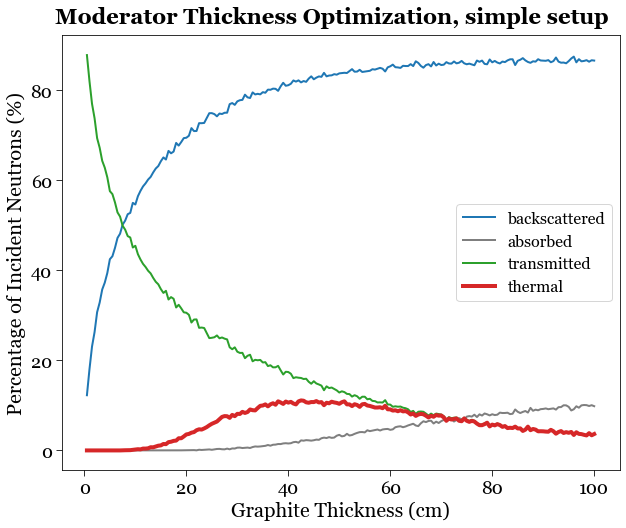

In [28]:
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()

ax.plot(d_counts, backscatter_counts, label='backscattered', color=tableau_colors[0], linewidth=2.0)
ax.plot(d_counts, absorb_counts, label='absorbed', color=tableau_colors[7], linewidth=2.0)
ax.plot(d_counts, transmit_counts, label='transmitted', color=tableau_colors[2], linewidth=2.0)
ax.plot(d_counts, thermal_counts, label='thermal', color=tableau_colors[3], linewidth=4.0)

# Customize tick sizes
ax.tick_params(axis='both', which='major', labelsize=18, length=6)  # Adjust label size and tick length
# ax.set_xlim(0, 300)
# ax.set_ylim(0, 1.2)
ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

# Customize the plot (optional)
plt.xlabel('Graphite Thickness (cm)', fontdict=font)
plt.ylabel('Percentage of Incident Neutrons (%)', fontdict=font)
plt.gcf().set_facecolor('white')
fig.suptitle('Moderator Thickness Optimization, simple setup', fontproperties=suptitle_font, y=0.93)
plt.legend(loc='center right', prop=legend_font)

# Show the plot
# plt.savefig('./plots/graphite_thickness.png')
plt.show()

In [45]:
# energy spectrum D=40
D_opt = 40
bin_opt = D_opt * 2 - 1

transmit_spectrum = histograms[bin_opt]
incident_spectrum = np.zeros(n_bin_energy)
for i in range(n_monte_carlo * 3):
    energy = get_neutron_energy()
    index = int(energy * 10)
    incident_spectrum[index] += 1


/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_12857/755888517.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_12857/755888517.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


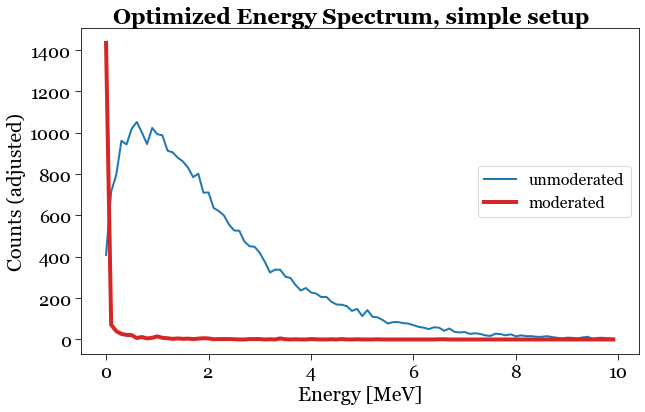

In [55]:
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.plot(np.array(range(100))/10, incident_spectrum, label='unmoderated', color=tableau_colors[0], linewidth=2.0)
ax.plot(np.array(range(100))/10, transmit_spectrum, label='moderated', color=tableau_colors[3], linewidth=4.0)

# Customize tick sizes
ax.tick_params(axis='both', which='major', labelsize=18, length=6)  # Adjust label size and tick length
# ax.set_xlim(0, 300)
# ax.set_ylim(0, 1.2)
ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

# Customize the plot (optional)
plt.xlabel('Energy [MeV]', fontdict=font)
plt.ylabel('Counts (adjusted)', fontdict=font)
plt.gcf().set_facecolor('white')
fig.suptitle('Optimized Energy Spectrum, simple setup', fontproperties=suptitle_font, y=0.93)
plt.legend(loc='center right', prop=legend_font)

# Show the plot
# plt.savefig('./plots/optimized_transmit_energies.png')
plt.show()

## 2. More Realistic Geometry
Graphite arranged in a cubic lattice. Fuel sphere at the center 

In [71]:
# geometry 
def fermi_lattice(D=20.0):
    """FOLLOW EACH NEUTRON UNTIL IT EXITS OR IS ABSORBED
    THE SOURCE IS AT THE ORIGIN OF COORDINATES"""
    # initialize counts, transmitted energy spectrum
    transmit_count, backscatter_count, absorb_count, thermal_count = 0, 0, 0, 0
    transmit_histogram = np.zeros(n_bin_energy)
    
    for ind in range(n_monte_carlo):
        x, y, z = 0.0, 0.0, 0.0
        energy = get_neutron_energy()
#         now the neutron can travel back to the other side
        zenith = math.acos(2 * random.random() - 1)
        azimuth = 2.0 * math.pi * random.random()

    #     unit velocity vector
        vx = math.sin(zenith) * math.cos(azimuth)
        vy = math.sin(zenith) * math.sin(azimuth)
        vz = math.cos(zenith)

    #     interaction
        while True:
            sigma_elastic, sigma_absorb = get_cross_sections(energy)
            sigma_interact = sigma_elastic + sigma_absorb
        #     deduce free propagation distance till the next by the interaction cross sections
            d_free_prop = -math.log(random.random()) * ATOM_NUMBER \
                        / (sigma_interact * DENSITY * AVOGADRO)
        #     new position
            x += vx * d_free_prop
            y += vy * d_free_prop
            z += vz * d_free_prop
        #     case: transmitted
            if (abs(x) > (D / 2)) or (abs(y) > (D / 2)) or (abs(z) > (D / 2)):
                transmit_count += 1
                index = int(energy * 10)
                transmit_histogram[index] += 1
                if energy < 5e-4:
                    thermal_count += 1
                break
        #     case: captured
            if random.random() < (sigma_absorb / sigma_interact):
                absorb_count += 1
                break
        #     case: elastic scattering
            energy, zenith = get_energy_loss(energy)
            vx, vy, vz = get_euler_angles(vx, vy, vz, zenith)
    
    scaling = 100 / n_monte_carlo
    return D, scaling * transmit_count, scaling * backscatter_count, \
              scaling * absorb_count, scaling * thermal_count, \
              transmit_histogram


In [78]:
histograms_lattice = []
d_range_lattice = 130
d_bin_lattice = d_range_lattice // 2

d_counts_lattice           = np.zeros(d_bin_lattice)
transmit_counts_lattice    = np.zeros(d_bin_lattice)
backscatter_counts_lattice = np.zeros(d_bin_lattice)
absorb_counts_lattice      = np.zeros(d_bin_lattice)
thermal_counts_lattice     = np.zeros(d_bin_lattice)

for i, D in enumerate(np.array(range(1, 2 * d_bin_lattice + 1, 2))):
    print(i, D)
    d, transmit, backscatter, absorb, thermal, histogram = fermi_lattice(D)
    d_counts_lattice[i]           = d
    transmit_counts_lattice[i]    = transmit
    backscatter_counts_lattice[i] = backscatter
    absorb_counts_lattice[i]      = absorb
    thermal_counts_lattice[i]     = thermal
    histograms_lattice.append(histogram)
    

0 1
1 3
2 5
3 7
4 9
5 11
6 13
7 15
8 17
9 19
10 21
11 23
12 25
13 27
14 29
15 31
16 33
17 35
18 37
19 39
20 41
21 43
22 45
23 47
24 49
25 51
26 53
27 55
28 57
29 59
30 61
31 63
32 65
33 67
34 69
35 71
36 73
37 75
38 77
39 79
40 81
41 83
42 85
43 87
44 89
45 91
46 93
47 95
48 97
49 99
50 101
51 103
52 105
53 107
54 109
55 111
56 113
57 115
58 117
59 119
60 121
61 123
62 125
63 127
64 129


/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_12857/364442755.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_12857/364442755.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


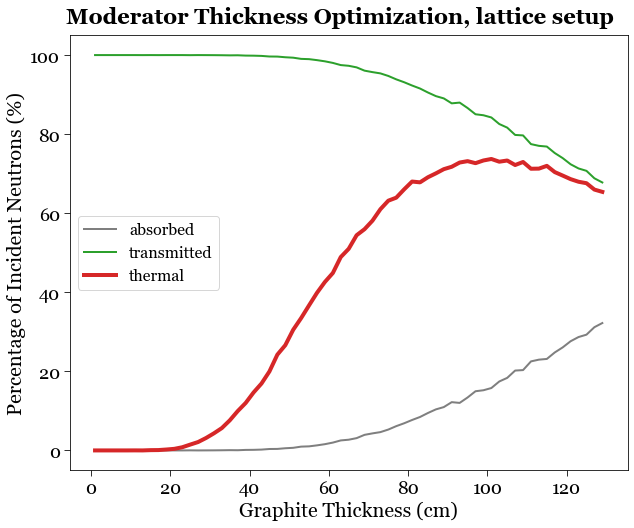

In [79]:
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()

ax.plot(d_counts_lattice, absorb_counts_lattice, label='absorbed', 
        color=tableau_colors[7], linewidth=2.0)
ax.plot(d_counts_lattice, transmit_counts_lattice, label='transmitted', 
        color=tableau_colors[2], linewidth=2.0)
ax.plot(d_counts_lattice, thermal_counts_lattice, label='thermal', 
        color=tableau_colors[3], linewidth=4.0)

# Customize tick sizes
ax.tick_params(axis='both', which='major', labelsize=18, length=6)  # Adjust label size and tick length
# ax.set_xlim(0, 300)
# ax.set_ylim(0, 1.2)
ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

# Customize the plot (optional)
plt.xlabel('Graphite Thickness (cm)', fontdict=font)
plt.ylabel('Percentage of Incident Neutrons (%)', fontdict=font)
plt.gcf().set_facecolor('white')
fig.suptitle('Moderator Thickness Optimization, lattice setup', fontproperties=suptitle_font, y=0.93)
plt.legend(loc='center left', prop=legend_font)

# Show the plot
plt.savefig('./plots/graphite_thickness_lattice.png')
plt.show()

In [84]:
# energy spectrum D=40
D_opt = 100
bin_opt = D_opt // 2

transmit_spectrum_lattice = histograms_lattice[bin_opt]
incident_spectrum_lattice = np.zeros(n_bin_energy)
for i in range(n_monte_carlo * 3):
    energy = get_neutron_energy()
    index = int(energy * 10)
    incident_spectrum[index] += 1


In [87]:
len(transmit_spectrum_lattice)

100

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_12857/4027228525.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_12857/4027228525.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


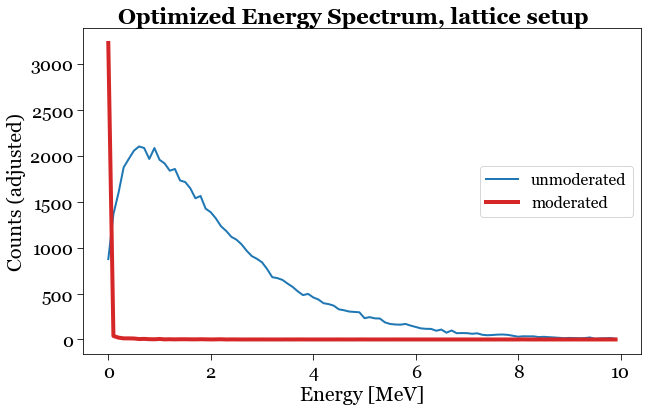

In [91]:
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.plot(np.array(range(100))/10, incident_spectrum, label='unmoderated', color=tableau_colors[0], linewidth=2.0)
ax.plot(np.array(range(100))/10, transmit_spectrum_lattice/2.5, label='moderated', color=tableau_colors[3], linewidth=4.0)

# Customize tick sizes
ax.tick_params(axis='both', which='major', labelsize=18, length=6)  # Adjust label size and tick length
# ax.set_xlim(0, 300)
# ax.set_ylim(0, 1.2)
ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

# Customize the plot (optional)
plt.xlabel('Energy [MeV]', fontdict=font)
plt.ylabel('Counts (adjusted)', fontdict=font)
plt.gcf().set_facecolor('white')
fig.suptitle('Optimized Energy Spectrum, lattice setup', fontproperties=suptitle_font, y=0.93)
plt.legend(loc='center right', prop=legend_font)

# Show the plot
plt.savefig('./plots/optimized_transmit_energies_lattice.png')
plt.show()

## More Realistic Cross-Sections

In [80]:
u235fission_data = np.loadtxt('./code/u235fission.in')
neutron_energies = u235fission_data[:, 0]
fisson_cross_sections = u235fission_data[:, 1]


In [83]:
len(neutron_energies)

31882

In [81]:
neutron_energies

array([1.000000e-11, 1.166093e-11, 1.332187e-11, ..., 1.900000e+01,
       1.950000e+01, 2.000000e+01])

In [82]:
fisson_cross_sections

array([3.10496684e+04, 2.87554099e+04, 2.69047439e+04, ...,
       1.93250000e+00, 1.93340000e+00, 1.93430000e+00])

In [ ]:
# to change 
# 1. make the cross section vs. neutron energy a dictionary
# 2. if needed write a linear interpolation 
# make sure the unit works
if (abs(x) > (D / 2)) or (abs(y) > (D / 2)) or (abs(z) > (D / 2)):
    transmit_count += 1
    index = int(energy * 10)
    cross_sections[index] += fisson_cross_sections[energy] # change this from count to granular... 
    if energy < 5e-4:
        thermal_count += 1
    break

In [ ]:
# geometry 
def fermi_tally(D=20.0):
    """FOLLOW EACH NEUTRON UNTIL IT EXITS OR IS ABSORBED
    THE SOURCE IS AT THE ORIGIN OF COORDINATES"""
    # initialize counts, transmitted energy spectrum
    transmit_count, backscatter_count, absorb_count, thermal_count = 0, 0, 0, 0
    transmit_histogram = np.zeros(n_bin_energy)
    
    for ind in range(n_monte_carlo):
        x, y, z = 0.0, 0.0, 0.0
        energy = get_neutron_energy()
#         now the neutron can travel back to the other side
        zenith = math.acos(2 * random.random() - 1)
        azimuth = 2.0 * math.pi * random.random()

    #     unit velocity vector
        vx = math.sin(zenith) * math.cos(azimuth)
        vy = math.sin(zenith) * math.sin(azimuth)
        vz = math.cos(zenith)

    #     interaction
        while True:
            sigma_elastic, sigma_absorb = get_cross_sections(energy)
            sigma_interact = sigma_elastic + sigma_absorb
        #     deduce free propagation distance till the next by the interaction cross sections
            d_free_prop = -math.log(random.random()) * ATOM_NUMBER \
                        / (sigma_interact * DENSITY * AVOGADRO)
        #     new position
            x += vx * d_free_prop
            y += vy * d_free_prop
            z += vz * d_free_prop
        #     case: transmitted
            if (abs(x) > (D / 2)) or (abs(y) > (D / 2)) or (abs(z) > (D / 2)):
                transmit_count += 1
                index = int(energy * 10)
                transmit_histogram[index] += 1
                if energy < 5e-4:
                    thermal_count += 1
                break
        #     case: captured
            if random.random() < (sigma_absorb / sigma_interact):
                absorb_count += 1
                break
        #     case: elastic scattering
            energy, zenith = get_energy_loss(energy)
            vx, vy, vz = get_euler_angles(vx, vy, vz, zenith)
    
    scaling = 100 / n_monte_carlo
    return D, scaling * transmit_count, scaling * backscatter_count, \
              scaling * absorb_count, scaling * thermal_count, \
              transmit_histogram
